In [177]:
from math import (
    exp,
    pi,
    sin,
    cos,
    sqrt,
    log
)
import matplotlib.pyplot as plt
import numpy
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy import integrate

## Problem 2
### (a)

Local max E(x): [0.0131644  5.01918046]
Local min E(x): [-2.99080534 -2.08638085]


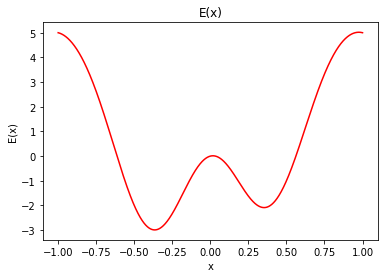

In [178]:
def energy_func(x):
    return 0.5 - 3 * cos(pi * x) + 2 * cos(2 * pi * x) + 0.5 * cos(3 * pi * x) + 0.5 * sin(pi * x)

x = numpy.linspace(-1, 1, 2000)
y = numpy.asarray([energy_func(j) for j in x])
plt.plot(x, y, color = "red")
plt.title("E(x)")
plt.xlabel("x")
plt.ylabel("E(x)")

print(f"Local max E(x): {y[argrelextrema(y, numpy.greater)]}")
print(f"Local min E(x): {y[argrelextrema(y, numpy.less)]}")

The local minima near $x = \pm 0.4$ are -2.99 and -2.09. The local maxima near $x = 0$ is 0.01. The energy barrier when starting at the local minima at $x = -0.4$ is $3$, while the energy barrier when starting at the local minima at $x = 0.4$ is $2.10$

### (b)

Integral of PDF(x): 0.9999999994415072


Text(0, 0.5, 'PDF(x)')

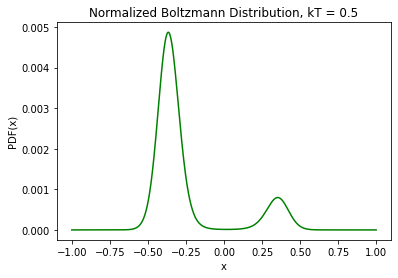

In [179]:
kT = 0.5
beta = 1 / kT

Z = 0
for i in x:
    Z += exp(-beta * energy_func(i))

def pdf_func(x):
    return exp(-beta * energy_func(x)) / Z

pdf = numpy.asarray([pdf_func(j) for j in x])
integral = numpy.trapz(pdf)
print(f"Integral of PDF(x): {integral}")

plt.plot(x, pdf, color = "green")
plt.title("Normalized Boltzmann Distribution, kT = 0.5")
plt.xlabel("x")
plt.ylabel(r"PDF(x)")

### (c)

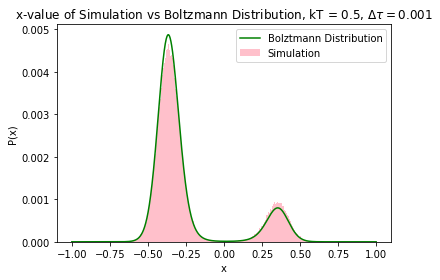

In [310]:
num_steps = 10 ** 6

# Our parameter to tune
gamma = 0.001

kT = 0.5
eta = sqrt(2 * kT / gamma)

def apply_pbc(x_coord):
    if x_coord > 1:
        delta = (x_coord + 1) % 2
        return -1 + delta
    elif x_coord < -1:
        delta = (x_coord - 1) % 2
        return -1 + delta
    return x_coord

def energy_derivative_func(x):
    return pi * 3 * sin(pi * x) - 4 * pi * sin(2 * pi * x) - 3 * pi / 2 * sin(3 * pi * x) + pi / 2 * cos(pi * x)

start_pos = 0.4
pos_list = [start_pos] * (num_steps + 1)

curr_pos = start_pos
for i in range(num_steps):
    g = numpy.random.normal(0, 1)
    curr_pos = apply_pbc(curr_pos + gamma * (-energy_derivative_func(curr_pos) + eta * g))
    pos_list[i+1] = curr_pos

plt.plot(x, pdf, color = "green", label = "Bolztmann Distribution")
weights = numpy.divide(numpy.ones_like(pos_list), len(pos_list))
bin_count, bins, _ = plt.hist(pos_list, weights = weights, bins = x, color = "pink", label = "Simulation")
plt.title(r"x-value of Simulation vs Boltzmann Distribution, kT = 0.5, $\Delta \tau = $" + f"{gamma}")
plt.xlabel("x")
plt.ylabel(r"P(x)")
plt.legend()

In [311]:
pdf_local_max = pdf[argrelextrema(pdf, numpy.greater)]
pdf_local_max_index = x[argrelextrema(pdf, numpy.greater)]

bin_index_1 = 0
while pdf_local_max_index[0] > bins[bin_index_1 + 1]:
    bin_index_1 += 1
bin_index_2 = 0
while pdf_local_max_index[1] > bins[bin_index_2 + 1]:
    bin_index_2 += 1

pct_diff_1 = round((bin_count[bin_index_1] - pdf_local_max[0]) / pdf_local_max[0] * 100, 2)
pct_diff_2 = round((bin_count[bin_index_2] - pdf_local_max[1]) / pdf_local_max[1] * 100, 2)
print(f"Percent difference between local max: {pct_diff_1}% and {pct_diff_2}%")

Percent difference between local max: -6.23% and 15.37%


My optimal value of $\Delta \tau = 0.001$

### (d)

In [312]:
num_samples = 2000

table_data = []
for kT in [0.4, 0.5, 0.6, 0.7, 0.8]:
    eta = sqrt(2 * kT / gamma)

    tau_list = []
    for i in range(num_samples):
        curr_pos = start_pos
        tau = 0
        while (curr_pos > 0):
            g = numpy.random.normal(0, 1)
            curr_pos = apply_pbc(curr_pos + gamma * (-energy_derivative_func(curr_pos) + eta * g))
            tau += 1
        tau_list.append(tau)
        #print(f"done with sample {i}")

    tau_mean = sum(tau_list) / num_samples
    sigma_est = 0
    for tau in tau_list:
        sigma_est += ((tau - tau_mean) ** 2)
    sigma_est = sqrt(sigma_est / (num_samples - 1))

    table_data.append([kT, tau_mean, sigma_est])

print("{:<16} {:<16} {:<16}".format("kT", "Mean of Tau", "Estimated Sigma of Tau"))
for entry in table_data:
    print("{:<16.1f} {:<16.6f} {:<16.6f}".format(entry[0], entry[1], entry[2]))

kT               Mean of Tau      Estimated Sigma of Tau
0.4              9224.967500      9235.734668     
0.5              3409.655500      3267.657859     
0.6              1673.441000      1652.594923     
0.7              984.735000       991.306595      
0.8              714.086000       668.532833      


### (e)

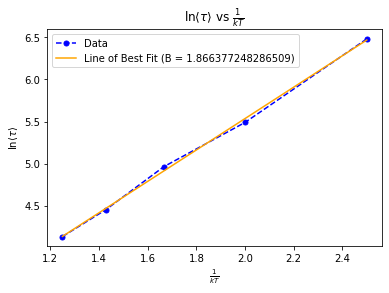

In [ ]:
log_taus = [log(entry[1]) for entry in table_data]
betas = [1 / entry[0] for entry in table_data]
plt.plot(betas, log_taus, color = "blue", ls = "--", marker = ".", ms = 10, label = "Data")

def linear_fit(x, B, c):
    return B * x + c

popt, _ = curve_fit(linear_fit, betas, log_taus)
B, c = popt[0], popt[1]
fit_y = [linear_fit(j, B, c) for j in betas]
plt.plot(betas, fit_y, color = "orange", label = f"Line of Best Fit (B = {B})")

plt.title(r"$\ln \langle \tau \rangle$ vs $\frac{1}{kT}$")
plt.xlabel(r"$\frac{1}{kT}$")
plt.ylabel(r"$\ln \langle \tau \rangle$")
plt.legend()

It agrees with my result from part (a) where I calculated the energy barrier when starting at $x = 0.4$ as $2.10$, which is roughly equal to the $B$ that we obtained after conducting a line of best fit